# Importing necessary things

In [1]:
import pandas as pd
import pickle
import bz2

import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                                                            
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

------------

# Looking at the dataframe

In [2]:
# Bring dataset from pickle

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [3]:
df = decompress_pickle('data/compressedpz.pbz2')
df

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response
84652123,84652123,"{'steamid': '76561198044182675', 'num_games_ow...",english,Don't get me wrong this game is amazing. I spe...,1610600299,1610600299,False,0,0,0,0,True,False,True,NaN,NaN
84650292,84650292,"{'steamid': '76561198189260829', 'num_games_ow...",english,ME LIKE!!,1610596706,1610596706,True,0,0,0,0,True,False,True,NaN,NaN
84647357,84647357,"{'steamid': '76561197968351158', 'num_games_ow...",english,Really good game. Make sure you opt into the b...,1610591400,1610591400,True,0,0,0,0,True,False,True,NaN,NaN
84646408,84646408,"{'steamid': '76561198025117668', 'num_games_ow...",english,Project Zomboid is THE zombie survival game. W...,1610589741,1610589741,True,0,0,0,0,True,False,True,NaN,NaN
84643897,84643897,"{'steamid': '76561198024526105', 'num_games_ow...",english,Less of an action-packed zombie apocalypse gam...,1610585302,1610585302,True,0,0,0,0,True,False,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7602280,7602280,"{'steamid': '76561198067098561', 'num_games_ow...",english,This is a must buy! It's a really unique game ...,1383932465,1383932465,True,0,0,0,0,False,False,True,NaN,NaN
7602237,7602237,"{'steamid': '76561198043807990', 'num_games_ow...",english,Fans of serious zombie survival games that is ...,1383932174,1385746707,True,20,0,0.715714693069458008,0,False,False,True,NaN,NaN
7602221,7602221,"{'steamid': '76561197981939207', 'num_games_ow...",brazilian,Esse jogo é muito bacana para quem gosta de um...,1383932039,1385658239,True,23,0,0.741350948810577393,0,False,False,True,NaN,NaN
7602166,7602166,"{'steamid': '76561198024263590', 'num_games_ow...",english,"2013:After a really, really long wait it's fin...",1383931617,1575136783,True,0,0,0,0,False,False,True,NaN,NaN


------

# Cleaning the data

In [4]:
# Checking for null values
# Almost all the reviews have no responses from the dev.

df.isna().sum()

recommendationid                   0
author                             0
language                           0
review                             0
timestamp_created                  0
timestamp_updated                  0
voted_up                           0
votes_up                           0
votes_funny                        0
weighted_vote_score                0
comment_count                      0
steam_purchase                     0
received_for_free                  0
written_during_early_access        0
timestamp_dev_responded        33976
developer_response             33976
dtype: int64

In [5]:
# Dropping columns that are not particularly useful.

df = df.drop(columns=['recommendationid', 'author', 'timestamp_updated', 'timestamp_dev_responded', 'developer_response', 'written_during_early_access'])
df.head()

,language,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,1610600299,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,1610596706,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,1610591400,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,1610589741,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,1610585302,True,0,0,0,0,True,False


In [6]:
import time

# Changing epoch time to readable format. Removing timestamp for ease of time series.
df['timestamp_created'] = [time.strftime('%Y-%m-%d', time.localtime(x)) for x in df['timestamp_created']]
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], format='%Y-%m-%d')

# Changing name of column for ease. 
df = df.rename(columns={'timestamp_created':'reviewtimeposted'})
df

,language,review,reviewtimeposted,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free
84652123,english,Don't get me wrong this game is amazing. I spe...,2021-01-13,False,0,0,0,0,True,False
84650292,english,ME LIKE!!,2021-01-13,True,0,0,0,0,True,False
84647357,english,Really good game. Make sure you opt into the b...,2021-01-13,True,0,0,0,0,True,False
84646408,english,Project Zomboid is THE zombie survival game. W...,2021-01-13,True,0,0,0,0,True,False
84643897,english,Less of an action-packed zombie apocalypse gam...,2021-01-13,True,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...
7602280,english,This is a must buy! It's a really unique game ...,2013-11-08,True,0,0,0,0,False,False
7602237,english,Fans of serious zombie survival games that is ...,2013-11-08,True,20,0,0.715714693069458008,0,False,False
7602221,brazilian,Esse jogo é muito bacana para quem gosta de um...,2013-11-08,True,23,0,0.741350948810577393,0,False,False
7602166,english,"2013:After a really, really long wait it's fin...",2013-11-08,True,0,0,0,0,False,False


-----

# Checking distribution of reviews

In [7]:
# About half the reviews are in English as indicated by the reviewers.

df['language'].value_counts()

english       16263
russian        6942
schinese       2300
spanish        1552
brazilian      1416
french         1236
koreana         877
turkish         745
german          722
polish          550
tchinese        223
japanese        202
italian         199
latam           132
czech           103
thai             99
portuguese       90
dutch            65
swedish          63
finnish          46
danish           42
hungarian        41
ukrainian        32
norwegian        27
bulgarian         7
greek             6
vietnamese        5
romanian          5
Name: language, dtype: int64

In [8]:
# A large majority of people reviewed the game positively.

df['voted_up'].value_counts()

True     30418
False     3572
Name: voted_up, dtype: int64

In [9]:
# A large majority of people who made reviews purchased the game on Steam.

df['steam_purchase'].value_counts()

True     25751
False     8239
Name: steam_purchase, dtype: int64

In [10]:
# A vast majority of people who made reviews paid for the game.

df['received_for_free'].value_counts()

False    33521
True       469
Name: received_for_free, dtype: int64

----

In [14]:
reviewcount = df['reviewtimeposted'].value_counts().rename_axis('date').reset_index(name='dailycount')
reviewcount = reviewcount.sort_values(by='date')
reviewcount.set_index('date', inplace=True)
reviewcount

,dailycount
date,
2013-11-08,58
2013-11-09,46
2013-11-10,37
2013-11-11,21
2013-11-12,22
...,...
2021-01-09,29
2021-01-10,39
2021-01-11,20


In [15]:
reviewcount.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2615 entries, 2013-11-08 to 2021-01-13
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   dailycount  2615 non-null   int64
dtypes: int64(1)
memory usage: 40.9 KB


In [19]:
reviewcountmonthly = reviewcount.resample('MS')
month_mean = reviewcountmonthly.mean()
month_mean

,dailycount
date,
2013-11-01,20.695652
2013-12-01,17.419355
2014-01-01,12.806452
2014-02-01,13.178571
2014-03-01,23.580645
...,...
2020-09-01,19.633333
2020-10-01,25.258065
2020-11-01,57.233333


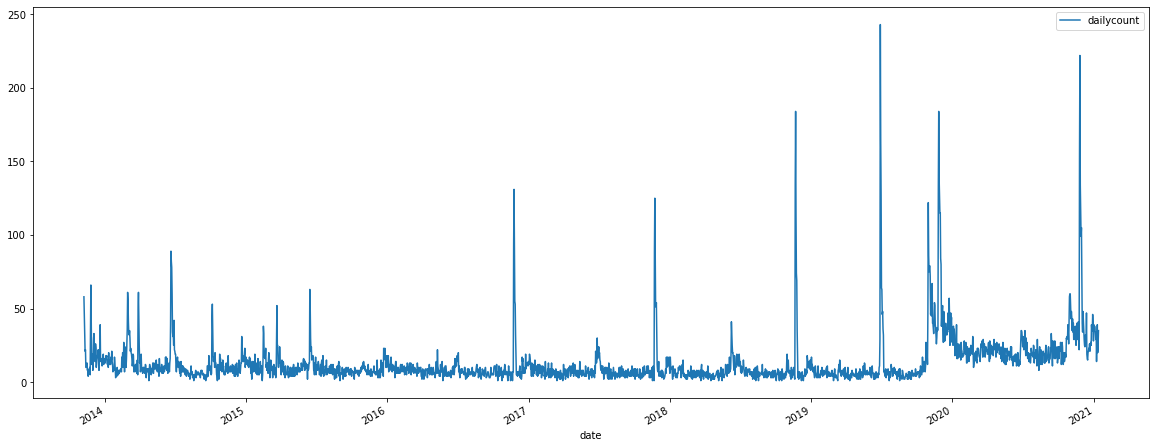

In [21]:
reviewcount.plot(figsize = (20,8))

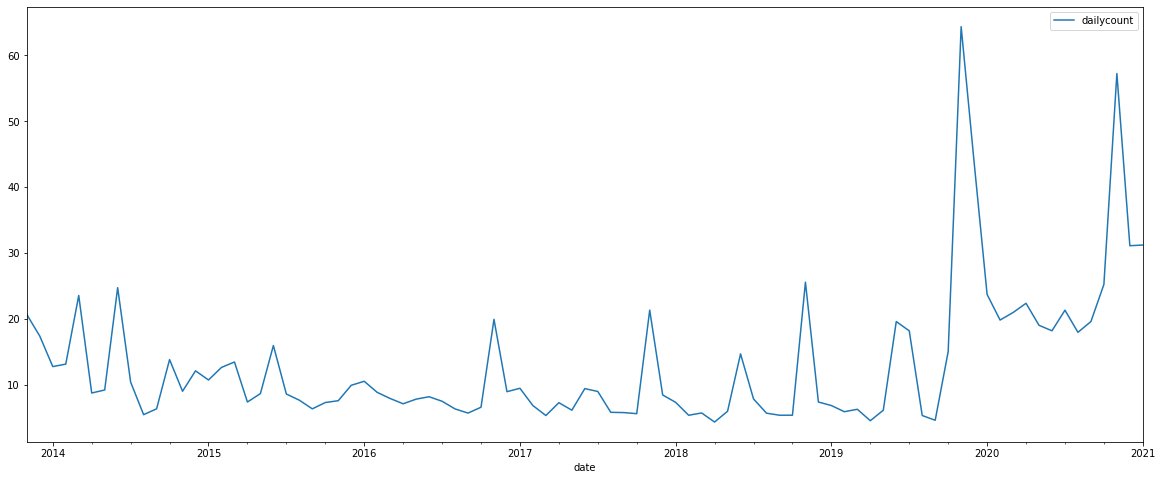

In [22]:
month_mean.plot(figsize = (20,8))